In [1]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

## Breast Cancer classification - Sigmoid

In this exercise I change the output layer to do classification. 

- Bruk breast cancer dataset. 
- Accuracy score: Number of correctly guessed targes divided by total targets. 
- Sjekk med ulike hyperparameter:
- Test resultata mot tensorflow/keras

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
from neural_network import NeuralNetwork
from sklearn.neural_network import MLPClassifier
import tqdm


In [120]:
import os
# Reading file into data frame
cwd = os.getcwd()
filename = cwd + '/breast-cancer-wisconsin.data'
nanDict = {}

#Read to dataframe and make header
col_names =  ["SampleCodeNumber", "ClumpThickness", "UniformityOfCellSize", 
              "UniformityOfCellShape", "MarginalAdhesion", "SingleEpithelialCellSize", 
              "BareNuclei", "BlandChromatin", "NormalNucleoli", "Mitoses", "Class"] 
df = pd.read_csv(filename, sep=',', names = col_names)

#Remove incomplete data according to ./breast-cancer-wisconsin.names
df = df[df.BareNuclei != '?']
#df = df.loc[:, df.columns != 'NormalNucleoli'] #why remove this? Logistic regression becomes less godd tho 
df = df.astype(float)
#df = df.loc[:, df.columns == 'Class'].astype(int)

# Features and targets, reads all data
x = df.loc[:, df.columns != 'Class'].values
x = x[:, 1:].astype(int)
#X = np.c_[np.ones((X.shape[0],1)), X]
y = df.loc[:, df.columns == 'Class'].values
y = (y == 4).astype(int)

In [121]:
x

array([[ 5,  1,  1, ...,  3,  1,  1],
       [ 5,  4,  4, ...,  3,  2,  1],
       [ 3,  1,  1, ...,  3,  1,  1],
       ...,
       [ 5, 10, 10, ...,  8, 10,  2],
       [ 4,  8,  6, ..., 10,  6,  1],
       [ 4,  8,  8, ..., 10,  4,  1]])

In [1]:

onehot = OneHotEncoder(sparse=False)
#my own implementation of one-hot encoding
#def to_categorical_numpy(integer_vector):
#    n_inputs = len(integer_vector)
#    n_categories = np.max(integer_vector) + 1
#    onehot_vector = np.zeros((n_inputs, n_categories))
#    onehot_vector[range(n_inputs), integer_vector] = 1 
#    return onehot_vector
#Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

batch_size = 64
learning_rate = np.logspace(-4, -3.2, 5) #learning rates narrowed down to interesting interval
regularization = np.linspace(0, 0.2, 3)

def output_func(z_h):
    return np.exp(z_h) / np.sum(np.exp(z_h), axis=1, keepdims=True)

k_folds = 5
batch_size = 32
n_epochs = 500
hidden_layer_sizes = [7, 7]

train_accuracy = np.zeros((len(learning_rate), len(regularization)))
test_accuracy = np.zeros((len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))
test_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

#my own implementation
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            y_test_onehot = onehot.fit_transform(y_test)
            y_train_onehot = onehot.fit_transform(y_train)
            n_categories = y_test_onehot.shape[1]
            dnn = NeuralNetwork(x_train, y_train_onehot, n_categories, output_func, eta=learning_rate[i], 
                                lmbd=regularization[j], epochs=n_epochs, batch_size=batch_size, 
                                activation_func = 'logistic',
                                hidden_layer_sizes=hidden_layer_sizes)

            
            dnn.train()            
            dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #de one-hot
            dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
            if not np.isnan(np.sum(dnn_ypred_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
            if not np.isnan(np.sum(dnn_ypred_train)):
                R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

        train_accuracy[i][j] = np.mean(R2_train)
        test_accuracy[i][j] = np.mean(R2_test)

NameError: name 'OneHotEncoder' is not defined

In [117]:
#sklearn
learning_rate = np.logspace(-4, -2, 5) #sklearn can handle larger 
regularization = np.linspace(0, 0.2, 3)
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            y_test_onehot = onehot.fit_transform(y_test)
            y_train_onehot = onehot.fit_transform(y_train)
            n_categories = y_test_onehot.shape[1]

            dnn = MLPClassifier(learning_rate_init=learning_rate[i], 
                                alpha=regularization[j], 
                                max_iter=2000, 
                                activation='logistic',
                                solver='adam',
                                verbose = False,
                                hidden_layer_sizes=hidden_layer_sizes)
            dnn.fit(x_train, y_train_onehot)
            #dnn.train()            
            dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #de one-hot
            dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
            if not np.isnan(np.sum(dnn_ypred_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
            if not np.isnan(np.sum(dnn_ypred_train)):
                R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

        train_accuracy_skl[i][j] = np.mean(R2_train)
        test_accuracy_skl[i][j] = np.mean(R2_test)


  0%|           | 0/5 [00:00<?, ?it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn

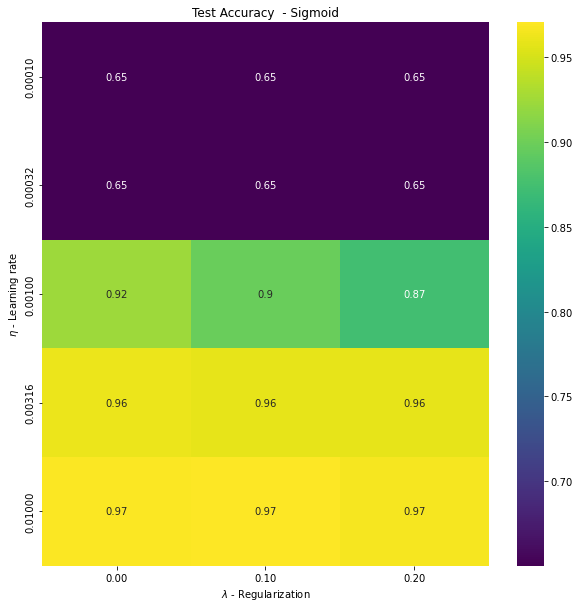

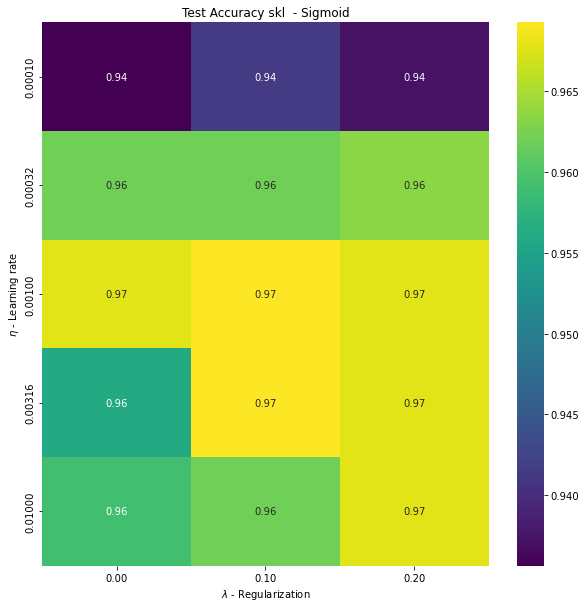

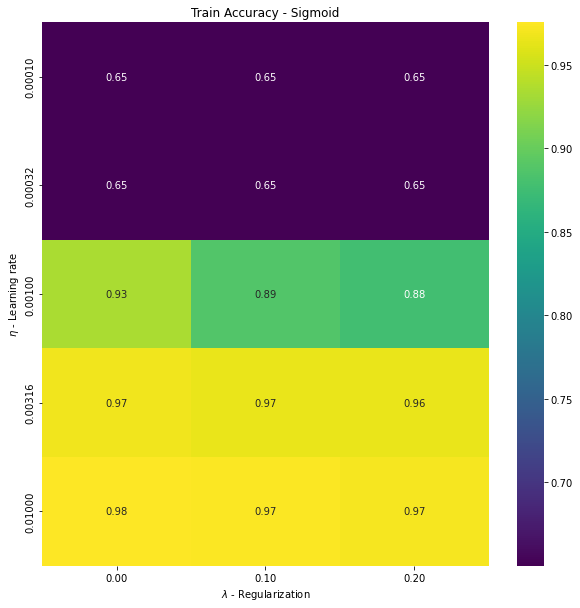

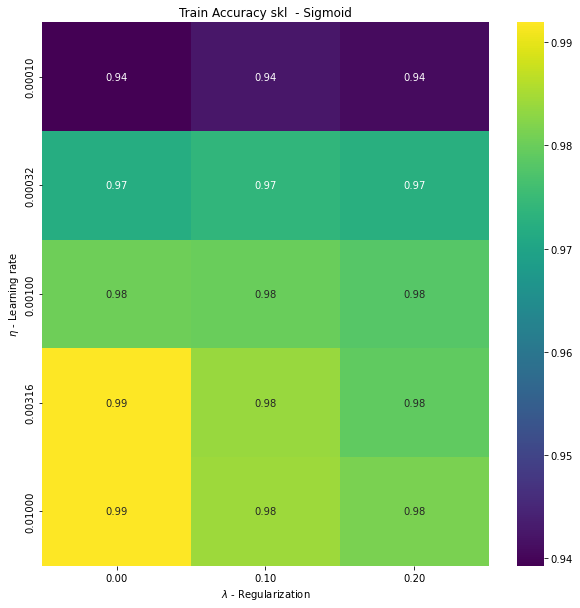

In [119]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy  - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy skl  - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy skl  - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

## Breast Cancer classification - RELU

In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
from sklearn.datasets import load_breast_cancer
from neural_network import NeuralNetwork
from sklearn.neural_network import MLPClassifier
import tqdm


cancer=load_breast_cancer()      
inputs=cancer.data                     
outputs=cancer.target                  
labels=cancer.feature_names[0:30]
x=inputs      
y=outputs.reshape(-1, 1)

onehot = OneHotEncoder(sparse=False)
#my own implementation of one-hot encoding
#def to_categorical_numpy(integer_vector):
#    n_inputs = len(integer_vector)
#    n_categories = np.max(integer_vector) + 1
#    onehot_vector = np.zeros((n_inputs, n_categories))
#    onehot_vector[range(n_inputs), integer_vector] = 1 
#    return onehot_vector
#Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

batch_size = 64
learning_rate = np.logspace(-5, -4.5, 5) #learning rates narrowed down to interesting interval
regularization = np.linspace(0, 0.2, 3)

def output_func(z_h):
    return np.exp(z_h) / np.sum(np.exp(z_h), axis=1, keepdims=True)

k_folds = 5
batch_size = 32
n_epochs = 1000
hidden_layer_sizes = [7, 7]

train_accuracy = np.zeros((len(learning_rate), len(regularization)))
test_accuracy = np.zeros((len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))
test_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

#my own implementation
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            y_test_onehot = onehot.fit_transform(y_test)
            y_train_onehot = onehot.fit_transform(y_train)
            n_categories = y_test_onehot.shape[1]
            dnn = NeuralNetwork(x_train, y_train_onehot, n_categories, output_func, eta=learning_rate[i], 
                                lmbd=regularization[j], epochs=n_epochs, batch_size=batch_size, 
                                activation_func = 'relu',
                                hidden_layer_sizes=hidden_layer_sizes)

            
            dnn.train()            
            dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #de one-hot
            dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
            if not np.isnan(np.sum(dnn_ypred_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
            if not np.isnan(np.sum(dnn_ypred_train)):
                R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

        train_accuracy[i][j] = np.mean(R2_train)
        test_accuracy[i][j] = np.mean(R2_test)


100%|███| 5/5 [05:08<00:00, 61.71s/it]


In [100]:
learning_rate = np.logspace(-3.5, -2, 5) #sklearn can take larger initial learning rates
regularization = np.linspace(0, 0.2, 3)
#sklearn
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            y_test_onehot = onehot.fit_transform(y_test)
            y_train_onehot = onehot.fit_transform(y_train)
            n_categories = y_test_onehot.shape[1]

            dnn = MLPClassifier(learning_rate_init=learning_rate[i], 
                                alpha=regularization[j], 
                                max_iter=2000, 
                                activation='relu',
                                solver='adam',
                                verbose = False,
                                hidden_layer_sizes=hidden_layer_sizes)
            dnn.fit(x_train, y_train_onehot)
            #dnn.train()            
            dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #de one-hot
            dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
            if not np.isnan(np.sum(dnn_ypred_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
            if not np.isnan(np.sum(dnn_ypred_train)):
                R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

        train_accuracy_skl[i][j] = np.mean(R2_train)
        test_accuracy_skl[i][j] = np.mean(R2_test)


 20%|▌  | 1/5 [00:18<01:14, 18.55s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|███| 5/5 [00:43<00:00,  8.68s/it]


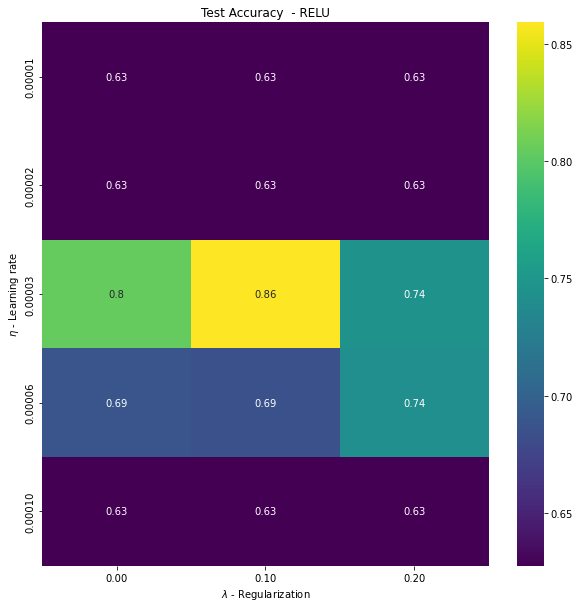

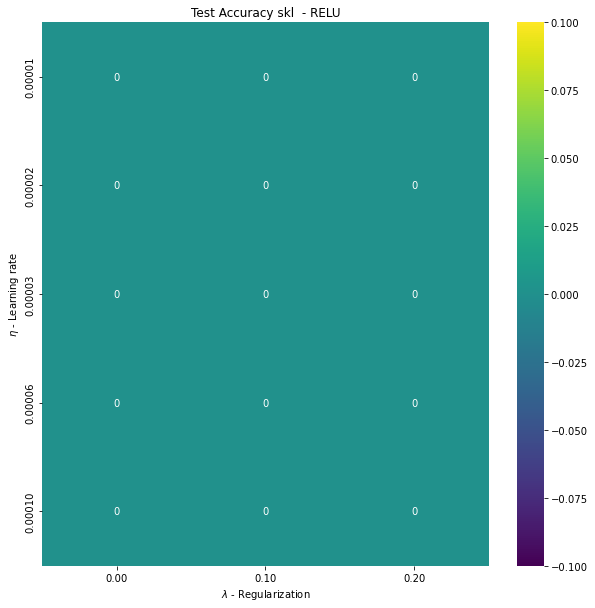

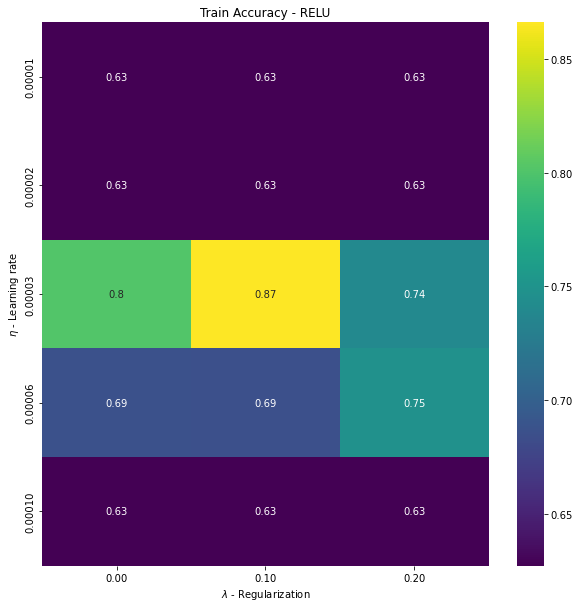

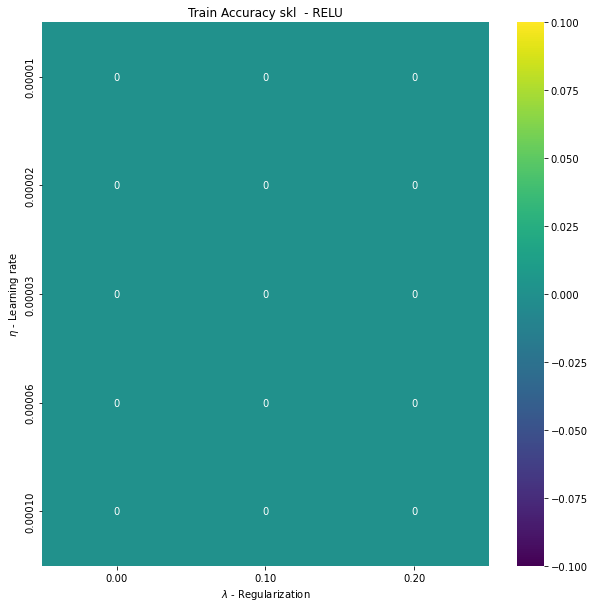

In [107]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy  - RELU")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy skl  - RELU")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy - RELU")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy skl  - RELU")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()